# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/'+
                 'Data_Cortex_Nuclear.xls', index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [24]:
df1 = df.fillna(df.mean())

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [25]:
ystr = df1['Genotype'].values
vals, y = np.unique(ystr, return_inverse=True)

As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [26]:
xnames = df1.columns[:-4]
X = np.array(df1[xnames].values)
Xs = preprocessing.scale(X)

Create a `LogisticRegression` object `logreg` and `fit` the training data.

In [27]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs,y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of time that the predictions match the true labels.  Below, we will properly measure the accuracy on cross-validation data.

In [28]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 1.000000


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<Container object of 3 artists>

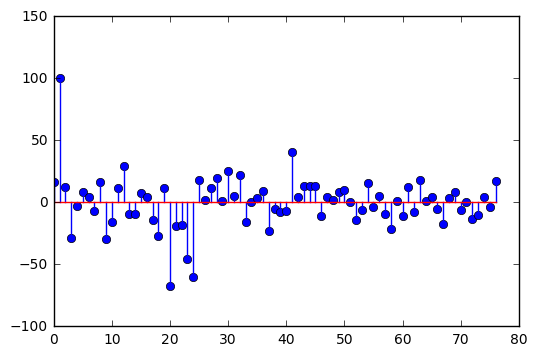

In [29]:
W = logreg.coef_
W = W.ravel()
plt.stem(W)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  Although, we do not discuss it in this class, there are ways to force the logistic regression to return a sparse vector `W`.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [30]:
ind = np.argsort(np.abs(W))
i1 = ind[-1]    # largest element
i2 = ind[-2]    # second largest element
name1 = xnames[i1]
name2 = xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(name1,name2))

The two most significant genes are ITSN1_N and BRAF_N


## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
err_rate = []

for Itr, Its in kf.split(Xs):
            
    # Get training and test data
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test data
    yhat = logreg.predict(Xts)
    
    # Measure the precision, recall and f1-score.
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    err_rate.append(np.mean(yts != yhat))

# Take the mean performance metrics over the different folds.
prec = np.mean(prec)
rec = np.mean(rec)
f1 = np.mean(f1)
err_mean = np.mean(err_rate)

print('Precision =  {0:.4f}'.format(prec))
print('Recall =     {0:.4f}'.format(rec))
print('f1 =         {0:.4f}'.format(f1))
print('error rate = {0:.4f}'.format(err_mean))

Precision =  0.9480
Recall =     0.9499
f1 =         0.9482
error rate = 0.0481


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [11]:
ystr = df1['class'].values
vals, y = np.unique(ystr, return_inverse=True)

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

In [12]:
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Measure the accuracy on the training data.

In [13]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 0.999074


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

logreg = linear_model.LogisticRegression()

# Initialize the confusion matrix counts
ny = np.max(y)
C = np.zeros((ny+1,ny+1))

# Create the cross-validation object
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
err_rate = np.zeros(nfold)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):
                
    # Get training and test data
    Itr, Its = Ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test set.
    yhat = logreg.predict(Xts)
    
    # Add the counts to the confusion matrix 
    # and store the error rate
    C += confusion_matrix(yts,yhat)
    err_rate[ifold] = np.mean(yhat != yts)    
    
# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[np.newaxis,:]

# Print the confusion matrix
print(np.array_str(C, precision=4, suppress_small=True))

# Print the overall error rate
err_mean = np.mean(err_rate)
err_se = np.std(err_rate)/np.sqrt(nfold-1)
print("Error rate = %12.4e, SE=%12.4e" % (err_mean,err_se))

[[ 0.9667  0.0074  0.0067  0.      0.0222  0.      0.      0.    ]
 [ 0.0067  0.9778  0.      0.      0.0074  0.0095  0.      0.    ]
 [ 0.      0.      0.9867  0.0148  0.      0.      0.      0.    ]
 [ 0.0067  0.      0.      0.9926  0.      0.      0.      0.    ]
 [ 0.0067  0.0148  0.      0.      0.9778  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      1.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      1.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      1.    ]]
Error rate =   1.2963e-02, SE=  1.5120e-03


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

<Container object of 3 artists>

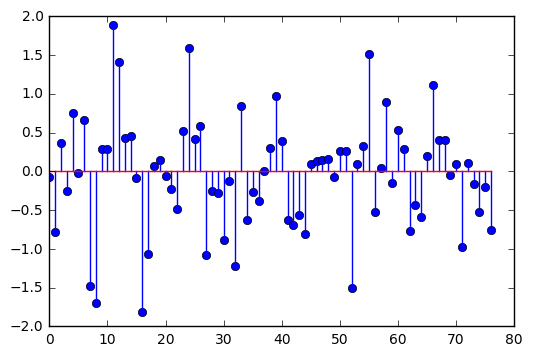

In [15]:
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y)
W = logreg.coef_

plt.stem(W[0,:])

## L1-Regularization

Graduate students only complete this section.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../model_sel/prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

In [16]:
# Penalty values to test
npen = 20
C_test = np.logspace(-1,3,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))

# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)
    
    print("Fold %d" % ifold)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


We compute the mean and standard error on the error rate for each `C` and plot the results.  We also print the minimum test error rate

The minimum test error rate =   6.4815e-03, SE=  1.9763e-03


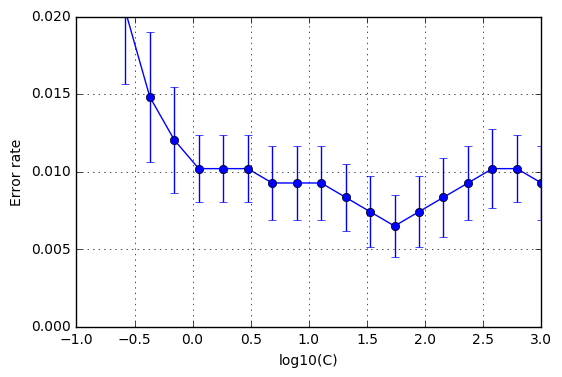

In [19]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0,0.02])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

imin = np.argmin(err_mean)
print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))

We see that the minimum error rate is significantly below the classifier that did not use the l1-penalty.  We will conclude by using the one SE rule to select an optimal `C`.

In [21]:
err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]

print("Optimal C=%12.4e" % C_opt)

Optimal C=  2.0691e+01


For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible.

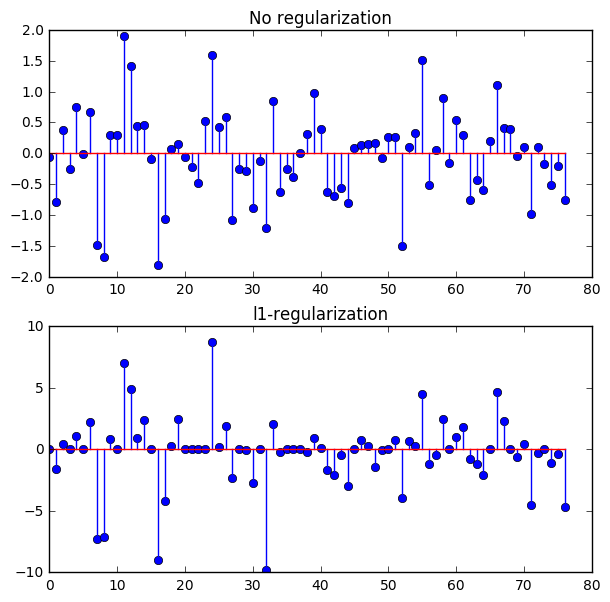

In [22]:
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.C= C_opt
logreg.fit(Xs,y)

W_l1 = logreg.coef_

plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
plt.stem(W_l1[0,:])
plt.title('l1-regularization')